In [1]:
%pip install cvxopt
import numpy as np
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   ------------------ --------------------- 6.0/12.8 MB 46.1 MB/s eta 0:00:01
   ---------------------------- ----------- 9.2/12.8 MB 30.0 MB/s eta 0:00:01
   ---------------------------------------  12.6/12.8 MB 23.9 MB/s eta 0:00:01
   ---------------------------------------- 12.8/12.8 MB 23.0 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


### Hard Margin SVM with `cvxopt` Library

In this section, we implement the Hard Margin SVM using the `cvxopt` library for convex optimization. We also incorporate multiple kernel functions to explore different decision boundaries. To achieve this, we optimize the following dual form of the SVM:

$$
\max_{\alpha} \; W(\alpha) = \sum_{i=1}^{m} \alpha_i - \frac{1}{2} \sum_{i,j=1}^{m} y^{(i)} y^{(j)} \alpha_i \alpha_j \langle x^{(i)}, x^{(j)} \rangle
$$

subject to:
$$
\alpha_i \geq 0, \quad i = 1, \dots, m
$$
and
$$
\sum_{i=1}^{m} \alpha_i y^{(i)} = 0
$$

This optimization problem is quadratic and subject to linear constraints.

### Standard Form for `cvxopt.solvers.qp`

The `cvxopt.solvers.qp` function solves problems in the following standard form:

$$
\begin{aligned}
&\min \frac{1}{2} x^T P x + q^T x \\
\text{subject to:} \quad & G x \leq h \\
& A x = b
\end{aligned}
$$


$$
\begin{aligned}
&\text{where:} \\
&x \text{ is the vector of variables we are solving for (in our case, the vector of Lagrange multipliers } \alpha\text{)} \\
&P \text{ is a matrix representing the quadratic coefficients of the objective function} \\
&q \text{ is a vector representing the linear coefficients of the objective function} \\
&G \text{ and } h \text{ represent inequality constraints} \\
&A \text{ and } b \text{ represent equality constraints}
\end{aligned}
$$


### Mapping the SVM Dual Problem to the QP Form

1. **Variables**:
   - Here, $$ x = \alpha $$, the vector of Lagrange multipliers.

2. **Objective Function**:
   - The dual objective function can be written as:
     $$
     W(\alpha) = \sum_{i=1}^{m} \alpha_i - \frac{1}{2} \sum_{i,j=1}^{m} y^{(i)} y^{(j)} \alpha_i \alpha_j K_{ij}
     $$
     where $$ K_{ij} = \langle x^{(i)}, x^{(j)} \rangle $$ is the Gram matrix (or kernel matrix).
   
   - Since `cvxopt` expects a minimization problem, we need to minimize $$ -W(\alpha) $$, which becomes:
     $$
     \min \; -\sum_{i=1}^{m} \alpha_i + \frac{1}{2} \sum_{i,j=1}^{m} y^{(i)} y^{(j)} \alpha_i \alpha_j K_{ij}
     $$

   - This gives:
     $$
     \begin{align}
     &\text{Matrix } P: & P_{ij} &= y^{(i)} y^{(j)} K_{ij} \\
     &\text{Vector } q: & q_i &= -1 \quad \text{(since the linear term is } -\sum_{i=1}^{m} \alpha_i \text{)}
     \end{align}
     $$

3. **Constraints**:
   $$
   \begin{align}
   &\text{Inequality Constraint } (\alpha_i \geq 0): & G &= -I \quad (\text{negative identity matrix}), \quad h = 0 \\
   &\text{Equality Constraint } \left(\sum_{i=1}^{m} \alpha_i y^{(i)} = 0\right): & A &= y^T \quad \text{(labels vector)}, \quad b = 0
   \end{align}
   $$


#### Kernel Functions

1. **Linear Kernel**  
   $$ K(x_1, x_2) = x_1 \cdot x_2 $$

2. **Polynomial Kernel**  
   $$ K(x_1, x_2) = (x_1 \cdot x_2 + \text{c})^{\text{degree}} $$


In [3]:
def compute_kernel_matrix(x, y, kwargs):

    kernel_type = kwargs['kernel_type']

    result = None

    ######## YOUR CODE HERE ########
    if kernel_type == "linear":
        result = x @ y.T
    else:
        if kernel_type == "gaussian":
            gamma = kwargs.get('gamma', 1.0)
            x_sq = np.sum(x**2, axis=1, keepdims=True)
            y_sq = np.sum(y**2, axis=1, keepdims=True).T
            dist2 = x_sq + y_sq - 2 * (x @ y.T)
            result = np.exp(-gamma * dist2)
        else:
            if kernel_type == "polynomial":
                degree = kwargs.get('degree', 1.0)
                c = kwargs.get('c', 1.0)
                result = (x @ y.T + c) ** degree
            else:
                raise ValueError("Unknown type")
    
    ################################
    
    return result

In [4]:
def find_alpha(X, y, K):

    n_samples, n_features = X.shape
    P_numpy, q_numpy, G_numpy, h_numpy, A_numpy, b_numpy = None, None, None, None, None, None

    # Convert inputs to cvxopt format
    ######### YOUR CODE HERE #########
    y = y.astype(float)
    n_samples = X.shape[0]
    P_numpy = (np.outer(y, y) * K)
    q_numpy = -np.ones(n_samples)
    G_numpy = -np.eye(n_samples)
    h_numpy = np.zeros(n_samples)
    A_numpy = y.reshape(1, -1)
    b_numpy = np.array([0.0])
    ##################################
    
    # Convert inputs to cvxopt format
    P = matrix(P_numpy, tc='d')
    q = matrix(q_numpy, tc='d')
    G = matrix(G_numpy, tc='d')
    h = matrix(h_numpy, tc='d')
    A = matrix(A_numpy, tc='d')
    b = matrix(b_numpy, tc='d')

    # Solve the QP problem to find Lagrange multipliers alpha
    solution = solvers.qp(P, q, G, h, A, b)
    alpha = np.ravel(solution['x'])

    return alpha

In [5]:
class HardMarginSVM:
    def __init__(self, kwargs=None):
        self.kwargs = kwargs
        self.support_vectors = None
        self.w = None
        self.b = None

    def kernel_function(self, x, y):
        return compute_kernel_matrix(x, y, self.kwargs)
        
    def fit(self, X, y):

        K = self.kernel_function(X, X)
        n_samples, n_features = X.shape

        # Solve the dual optimization problem to obtain the Lagrange multipliers
        self.alpha = find_alpha(X, y, K)

        # Select support vectors
        support_vector_indices = self.alpha > 1e-8 
        self.alpha = self.alpha[support_vector_indices]
        self.support_vectors = X[support_vector_indices]
        self.support_vector_labels = y[support_vector_indices]

        # Compute the bias term b
        self.b = None
        ######### YOUR CODE HERE #########
        K_sv = self.kernel_function(self.support_vectors, self.support_vectors)
        self.b = np.mean(
            self.support_vector_labels
            - (self.alpha * self.support_vector_labels) @ K_sv
        )

        ##################################    

    def predict(self, X):

        pred = None

        ######### YOUR CODE HERE #########
        K_x = self.kernel_function(self.support_vectors, X)  # (n_sv, n)
        decision = (self.alpha * self.support_vector_labels) @ K_x + self.b
        pred = np.sign(decision)

        ##################################

        return pred

    def plot_decision_boundary(self, X, y):
        plt.figure(figsize=(10, 6))
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', marker='o', s=30, edgecolors='k', label='Data Points')
        plt.scatter(self.support_vectors[:, 0], self.support_vectors[:, 1], s=100, linewidth=1, facecolors='none',
                    edgecolors='k', label='Support Vectors')

        # Plot decision boundary
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
        grid = np.c_[xx.ravel(), yy.ravel()]
        Z = self.predict(grid).reshape(xx.shape)

        plt.contourf(xx, yy, Z, alpha=0.3, cmap='bwr')
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.legend()
        plt.show()

        

     pcost       dcost       gap    pres   dres
 0: -1.4444e+00 -3.5309e+00  1e+02  1e+01  1e+00
 1: -6.8936e-02 -3.7882e+00  8e+00  4e-01  4e-02
 2: -7.6053e-01 -1.8644e+00  1e+00  8e-16  6e-16
 3: -9.5494e-01 -1.2515e+00  3e-01  8e-16  4e-16
 4: -9.9053e-01 -1.2706e+00  3e-01  5e-16  4e-16
 5: -1.1288e+00 -1.2389e+00  1e-01  3e-16  4e-16
 6: -1.1991e+00 -1.2177e+00  2e-02  7e-16  5e-16
 7: -1.2125e+00 -1.2136e+00  1e-03  2e-17  5e-16
 8: -1.2133e+00 -1.2133e+00  2e-05  5e-16  6e-16
 9: -1.2133e+00 -1.2133e+00  2e-07  7e-16  5e-16
Optimal solution found.
Linear SVM results:


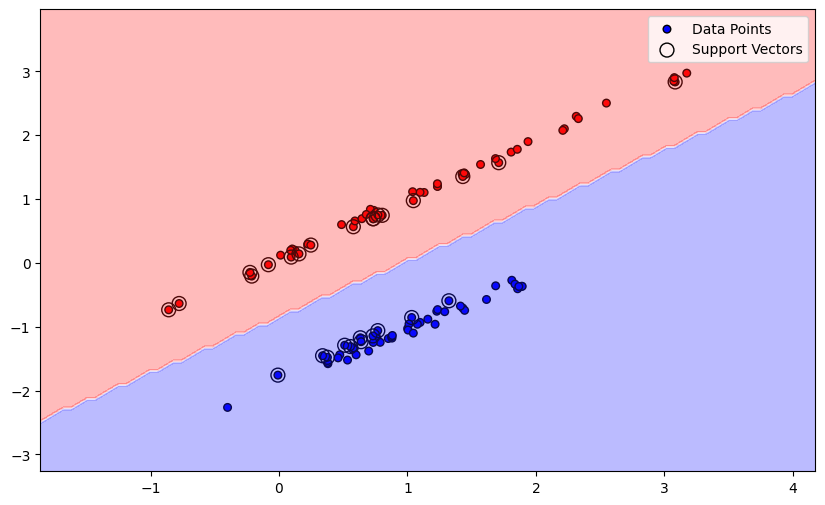

     pcost       dcost       gap    pres   dres
 0: -9.9973e+01 -2.0309e+02  1e+02  3e-15  2e+00
 1: -2.4443e+02 -2.4734e+02  3e+00  1e-14  1e+00
 2: -2.0790e+04 -2.0793e+04  3e+00  2e-12  1e+00
 3: -1.2732e+08 -1.2732e+08  2e+02  2e-08  1e+00
 4: -6.1890e+10 -6.1890e+10  1e+05  3e-06  1e+00
Terminated (singular KKT matrix).
Non-linear SVM results:


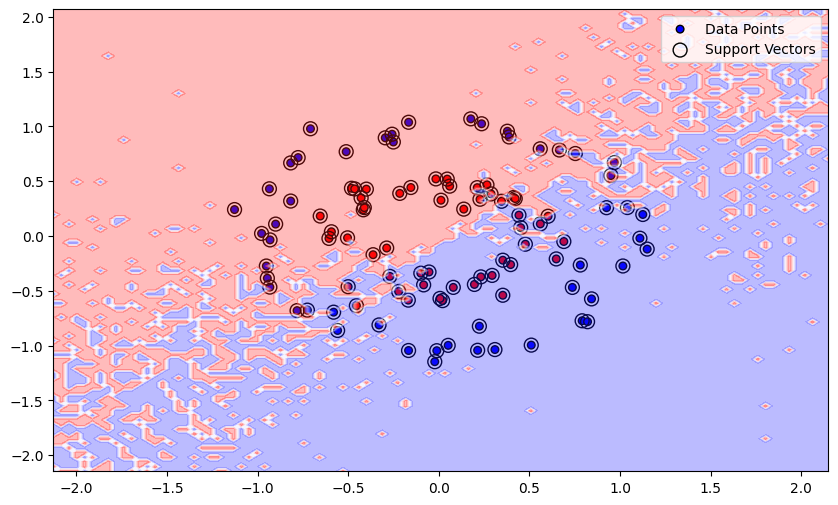

     pcost       dcost       gap    pres   dres
 0: -1.3776e+01 -3.2649e+01  3e+02  2e+01  2e+00
 1: -2.4081e+01 -3.4810e+01  1e+02  5e+00  6e-01
 2: -3.5863e+01 -4.2570e+01  9e+01  4e+00  4e-01
 3: -3.0132e+01 -3.4463e+01  3e+01  1e+00  1e-01
 4: -2.8944e+01 -3.1148e+01  3e+00  4e-02  5e-03
 5: -3.0245e+01 -3.0773e+01  6e-01  4e-03  5e-04
 6: -3.0664e+01 -3.0691e+01  3e-02  2e-04  3e-05
 7: -3.0686e+01 -3.0687e+01  7e-04  4e-06  4e-07
 8: -3.0687e+01 -3.0687e+01  2e-05  4e-08  5e-09
Optimal solution found.
Gaussian SVM results:


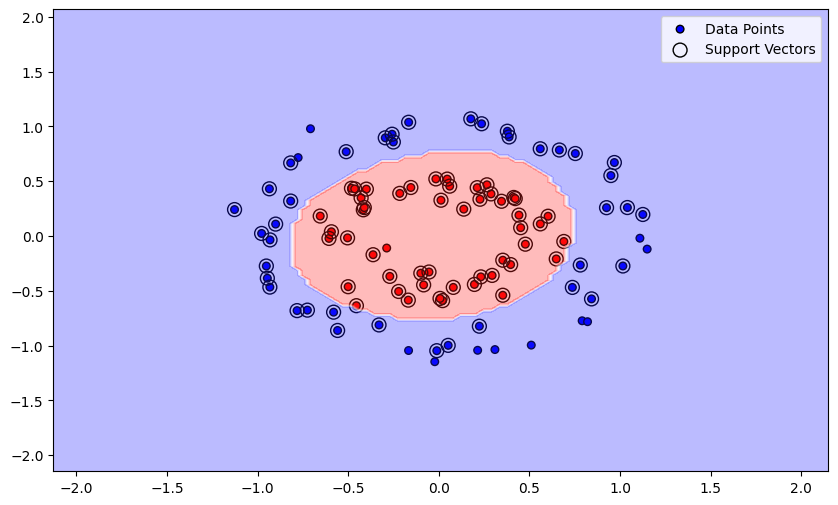

In [6]:
# Generate a linearly separable dataset with support vectors closer to the decision boundary
def generate_linear_data():
    from sklearn.datasets import make_classification
    X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, class_sep=1.0, random_state=42)
    y = np.where(y == 0, -1, 1)
    return X, y

# Generate a non-linearly separable dataset
def generate_nonlinear_data():
    from sklearn.datasets import make_circles
    X, y = make_circles(n_samples=100, factor=0.5, noise=0.1)
    y = np.where(y == 0, -1, 1)
    return X, y

X_linear, y_linear = generate_linear_data()
X_no, y_no = generate_nonlinear_data()

dict_linear = {'kernel_type': 'linear'}
dict_gaussian = {'kernel_type': 'gaussian', 'gamma': 1}
dict_polynomial = {'kernel_type': 'polynomial', 'c': 1, 'degree': 3}

svm_linear = HardMarginSVM(dict_linear)
svm_linear.fit(X_linear, y_linear)
print("Linear SVM results:")
svm_linear.plot_decision_boundary(X_linear, y_linear)

svm_linear.fit(X_no, y_no)
print("Non-linear SVM results:")
svm_linear.plot_decision_boundary(X_no, y_no)

svm_gaussian = HardMarginSVM(dict_polynomial)
svm_gaussian.fit(X_no, y_no)
print("Gaussian SVM results:")
svm_gaussian.plot_decision_boundary(X_no, y_no)

### Soft Margin SVM with `cvxopt` Library

For the Soft Margin SVM, we allow for some misclassification errors by introducing a regularization parameter $C$ that controls the trade-off between maximizing the margin and minimizing the classification error. This introduces slack variables, modifying the optimization problem to allow a degree of violation for points that cannot be perfectly separated.

The dual formulation for the Soft Margin SVM is as follows:

$$
\max_{\alpha} \; W(\alpha) = \sum_{i=1}^{m} \alpha_i - \frac{1}{2} \sum_{i,j=1}^{m} y^{(i)} y^{(j)} \alpha_i \alpha_j \langle x^{(i)}, x^{(j)} \rangle
$$

subject to:
$$
0 \leq \alpha_i \leq C, \quad i = 1, \dots, m
$$
and
$$
\sum_{i=1}^{m} \alpha_i y^{(i)} = 0
$$

### Standard Form for `cvxopt.solvers.qp`

The `cvxopt.solvers.qp` function solves problems in the following standard form:

$$
\begin{aligned}
&\min \frac{1}{2} x^T P x + q^T x \\
\text{subject to:} \quad & G x \leq h \\
& A x = b
\end{aligned}
$$

where:
- $x$ is the vector of variables we are solving for (in our case, the vector of Lagrange multipliers $\alpha$),
- $P$ is a matrix representing the quadratic coefficients of the objective function,
- $q$ is a vector representing the linear coefficients of the objective function,
- $G$ and $h$ represent inequality constraints,
- $A$ and $b$ represent equality constraints.

### Mapping the Soft Margin SVM Dual Problem to the QP Form

1. **Variables**:
   - Here, $x = \alpha$, the vector of Lagrange multipliers.

2. **Objective Function**:
   - The dual objective function can be written as:
     $$
     W(\alpha) = \sum_{i=1}^{m} \alpha_i - \frac{1}{2} \sum_{i,j=1}^{m} y^{(i)} y^{(j)} \alpha_i \alpha_j K_{ij}
     $$
     where $K_{ij} = \langle x^{(i)}, x^{(j)} \rangle$ is the Gram matrix (or kernel matrix).
   
   - Since `cvxopt` expects a minimization problem, we need to minimize $-W(\alpha)$, which becomes:
     $$
     \min \; -\sum_{i=1}^{m} \alpha_i + \frac{1}{2} \sum_{i,j=1}^{m} y^{(i)} y^{(j)} \alpha_i \alpha_j K_{ij}
     $$

   - This gives:
     $$
     \begin{align}
     &\text{Matrix } P: & P_{ij} &= y^{(i)} y^{(j)} K_{ij} \\
     &\text{Vector } q: & q_i &= -1 \quad \text{(since the linear term is } -\sum_{i=1}^{m} \alpha_i \text{)}
     \end{align}
     $$

3. **Constraints**:
   - Inequality Constraints: We have $0 \leq \alpha_i \leq C$, which translates to:
     $$
     G = \begin{bmatrix} -I \\ I \end{bmatrix}, \quad h = \begin{bmatrix} 0 \\ C \end{bmatrix}
     $$
     where $-I$ and $I$ represent the negative and positive identity matrices, respectively, ensuring $\alpha$ values remain within the interval $[0, C]$.

   - Equality Constraint $\left(\sum_{i=1}^{m} \alpha_i y^{(i)} = 0\right)$:
     $$
     A = y^T \quad \text{(labels vector)}, \quad b = 0
     $$


In [7]:
def find_alpha_soft(X, y, K, C):

    n_samples, n_features = X.shape
    P_numpy, q_numpy, G_numpy, h_numpy, A_numpy, b_numpy = None, None, None, None, None, None

    # Convert inputs to cvxopt format
    ######### YOUR CODE HERE #########
    y = y.astype(float)
    P_numpy = (np.outer(y, y) * K)
    q_numpy = -np.ones(n_samples)
    G_numpy = np.vstack([-np.eye(n_samples), np.eye(n_samples)])
    h_numpy = np.hstack([np.zeros(n_samples), C * np.ones(n_samples)])
    A_numpy = y.reshape(1, -1)
    b_numpy = np.array([0.0])
    ##################################
    
    # Convert inputs to cvxopt format
    P = matrix(P_numpy, tc='d')
    q = matrix(q_numpy, tc='d')
    G = matrix(G_numpy, tc='d')
    h = matrix(h_numpy, tc='d')
    A = matrix(A_numpy, tc='d')
    b = matrix(b_numpy, tc='d')

    # Solve the QP problem to find Lagrange multipliers alpha
    solution = solvers.qp(P, q, G, h, A, b)
    alpha = np.ravel(solution['x'])

    return alpha

In [12]:
import numpy as np
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt

class SoftMarginSVM:
    def __init__(self, kwargs=None):
        self.kwargs = kwargs
        self.C = kwargs['C']
        self.alpha = None
        self.support_vectors = None
        self.w = None
        self.b = None

    def kernel_function(self, x, y):
        return compute_kernel_matrix(x, y, self.kwargs)

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Compute the Kernel matrix
        K = self.kernel_function(X, X)

        self.alpha = find_alpha_soft(X, y, K, self.C)

        # Select support vectors
        support_vector_indices = (self.alpha > 1e-8) & (self.alpha < self.kwargs.get('C', np.inf))
        self.alpha = self.alpha[support_vector_indices]
        self.support_vectors = X[support_vector_indices]
        self.support_vector_labels = y[support_vector_indices]

        # Compute the bias term b
        ######### YOUR CODE HERE #########
        y = y.astype(float)
        alpha_full = find_alpha_soft(X, y, K, self.C) 
        eps = 1e-8
        sv_mask_for_b = (alpha_full > eps) & (alpha_full < self.C - eps)
        if not np.any(sv_mask_for_b):
            sv_mask_for_b = alpha_full > eps
        SVb = X[sv_mask_for_b]
        ySVb = y[sv_mask_for_b]
        K_sv_b = self.kernel_function(self.support_vectors, SVb)
        self.b = np.mean(
            ySVb - (self.alpha * self.support_vector_labels) @ K_sv_b
        )
        ##################################

    def predict(self, X):

        pred = None 

        ######### YOUR CODE HERE #########
        K_x = self.kernel_function(self.support_vectors, X)
        decision = (self.alpha[self.alpha > 1e-8] * self.support_vector_labels) @ K_x + self.b
        pred = np.sign(decision)
        pred[pred == 0] = 1

        ##################################

        return pred

    def plot_decision_boundary(self, X, y):
        plt.figure(figsize=(10, 6))
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', marker='o', s=30, edgecolors='k', label='Data Points')
        plt.scatter(self.support_vectors[:, 0], self.support_vectors[:, 1], s=100, linewidth=1, facecolors='none',
                    edgecolors='k', label='Support Vectors')

        # Plot decision boundary
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
        grid = np.c_[xx.ravel(), yy.ravel()]
        Z = self.predict(grid).reshape(xx.shape)

        plt.contourf(xx, yy, Z, alpha=0.3, cmap='bwr')
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.legend()
        plt.show()


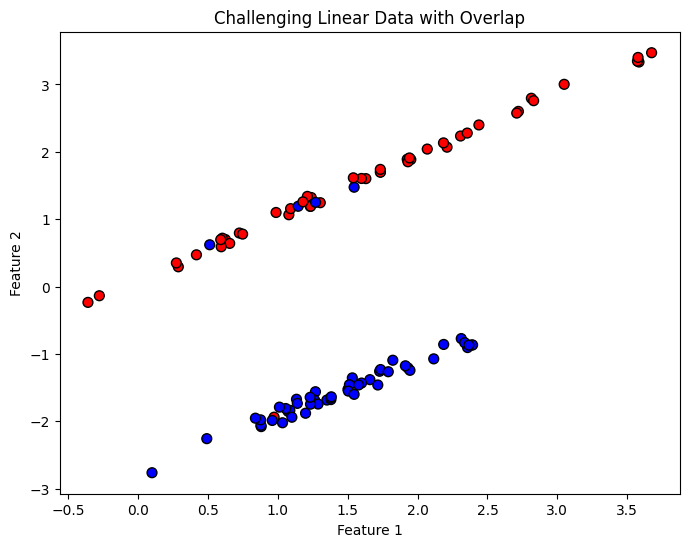

     pcost       dcost       gap    pres   dres
 0: -1.9787e+01 -6.4557e+01  3e+02  1e+01  3e+00
 1: -1.0705e+02 -1.8552e+02  2e+02  5e+00  1e+00
 2: -1.9464e+02 -2.9366e+02  2e+02  5e+00  1e+00
 3: -5.6238e+02 -7.0016e+02  2e+02  4e+00  1e+00
 4: -1.5634e+03 -1.8061e+03  3e+02  4e+00  1e+00
 5: -5.0610e+03 -5.6106e+03  6e+02  4e+00  1e+00
 6: -1.6544e+04 -1.8099e+04  2e+03  4e+00  1e+00
 7: -4.2199e+04 -4.5889e+04  4e+03  4e+00  1e+00
 8: -9.2790e+04 -1.0179e+05  9e+03  4e+00  1e+00
 9: -1.7998e+05 -2.0177e+05  2e+04  3e+00  1e+00
10: -2.8169e+05 -3.2391e+05  4e+04  3e+00  9e-01
11: -4.2004e+05 -5.0509e+05  9e+04  3e+00  8e-01
12: -7.7421e+05 -1.0097e+06  2e+05  1e+00  3e-01
13: -8.1175e+05 -8.7507e+05  6e+04  2e-01  7e-02
14: -8.0904e+05 -8.5533e+05  5e+04  1e-01  4e-02
15: -8.2245e+05 -8.2630e+05  4e+03  8e-04  2e-04
16: -8.2517e+05 -8.2523e+05  6e+01  1e-05  3e-06
17: -8.2522e+05 -8.2522e+05  6e-01  1e-07  3e-08
18: -8.2522e+05 -8.2522e+05  6e-03  1e-09  4e-10
Optimal solution foun

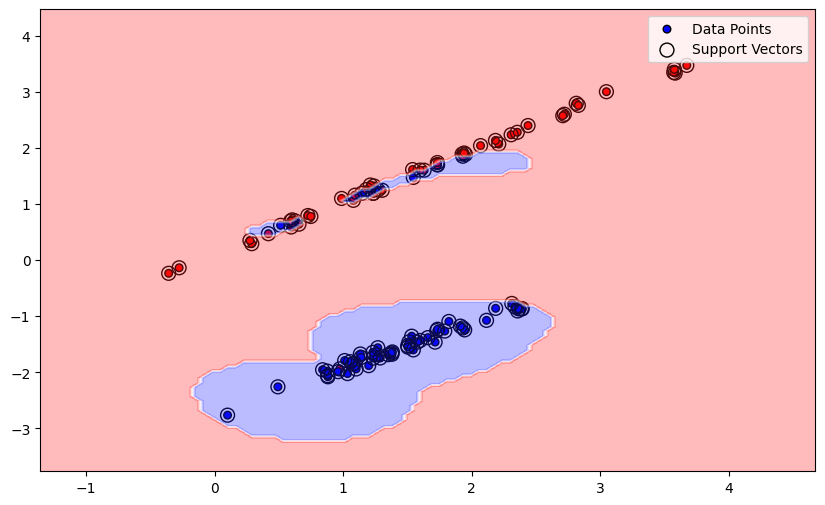

     pcost       dcost       gap    pres   dres
 0: -1.4048e+01 -1.0609e+02  1e+03  6e+00  4e-15
 1: -5.8706e+00 -7.5533e+01  1e+02  3e-01  3e-15
 2: -4.9843e+00 -1.1119e+01  6e+00  2e-16  2e-15
 3: -5.3878e+00 -6.0486e+00  7e-01  2e-16  1e-15
 4: -5.4374e+00 -5.9477e+00  5e-01  2e-16  1e-15
 5: -5.5147e+00 -5.7400e+00  2e-01  2e-16  1e-15
 6: -5.5557e+00 -5.7106e+00  2e-01  2e-16  1e-15
 7: -5.5878e+00 -5.6683e+00  8e-02  3e-16  1e-15
 8: -5.5998e+00 -5.6449e+00  5e-02  3e-16  1e-15
 9: -5.6088e+00 -5.6327e+00  2e-02  2e-16  1e-15
10: -5.6132e+00 -5.6263e+00  1e-02  3e-16  1e-15
11: -5.6187e+00 -5.6198e+00  1e-03  2e-16  1e-15
12: -5.6191e+00 -5.6194e+00  3e-04  3e-16  1e-15
13: -5.6192e+00 -5.6192e+00  1e-05  2e-16  1e-15
14: -5.6192e+00 -5.6192e+00  1e-07  2e-16  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.4048e+01 -1.0609e+02  1e+03  6e+00  4e-15
 1: -5.8706e+00 -7.5533e+01  1e+02  3e-01  3e-15
 2: -4.9843e+00 -1.1119e+01  6e+00  2e-16  2e-1

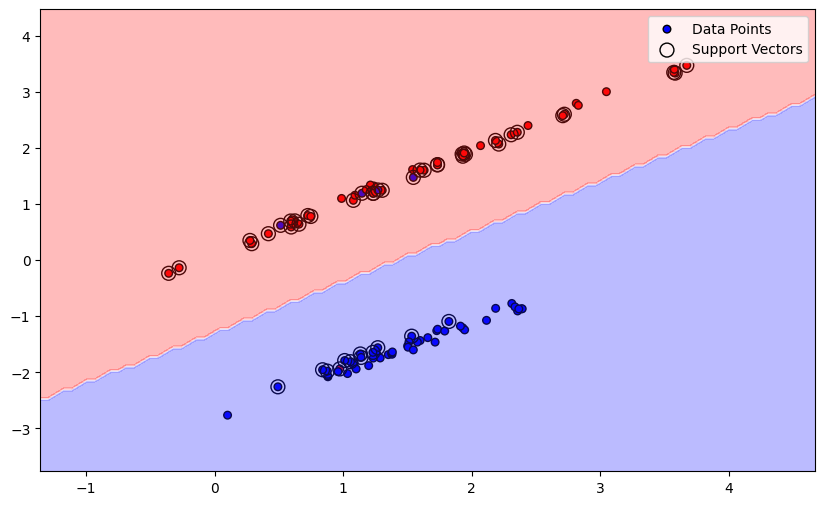

In [13]:
# Define a function to generate overlapping linear data
def generate_challenging_linear_data():
    # Generate a mostly separable dataset
    X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, 
                               n_clusters_per_class=1, class_sep=1.5, random_state=42)
    y = np.where(y == 0, -1, 1)

    # Introduce some overlap by adding noise
    np.random.seed(42)
    n_overlap = 5  # number of overlapping points
    overlap_indices = np.random.choice(range(50, 100), n_overlap, replace=False)
    
    # Flip the labels of the overlapping points to create misclassifications
    y[overlap_indices] = -y[overlap_indices]
    
    return X, y

# Generate the overlapping linear data
X_challenging, y_challenging = generate_challenging_linear_data()

# Plot the data to visualize the overlap
plt.figure(figsize=(8, 6))
plt.scatter(X_challenging[:, 0], X_challenging[:, 1], c=y_challenging, cmap='bwr', marker='o', s=50, edgecolors='k')
plt.title("Challenging Linear Data with Overlap")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

dict_linear = {'kernel_type': 'linear'}
dict_gaussian = {'kernel_type': 'gaussian', 'gamma': 1}
dict_polynomial = {'kernel_type': 'polynomial', 'c': 1, 'degree': 3}
# Try to fit a Hard Margin SVM (will likely fail)
try:
    
    hard_margin_svm = HardMarginSVM(dict_gaussian)
    hard_margin_svm.fit(X_challenging, y_challenging)
    print("Hard Margin SVM results:")
    hard_margin_svm.plot_decision_boundary(X_challenging, y_challenging)
except Exception as e:
    print("Hard Margin SVM failed due to non-separable data:", e)


dict_linear = {'kernel_type': 'linear', 'C': 0.5}
dict_gaussian = {'kernel_type': 'gaussian', 'gamma': 1, 'C': 1}
dict_polynomial = {'kernel_type': 'polynomial', 'c': 1, 'degree': 3, 'C': 1}
# Fit a Soft Margin SVM (should succeed with overlapping data)
soft_margin_svm = SoftMarginSVM(dict_linear)
soft_margin_svm.fit(X_challenging, y_challenging)
print("Soft Margin SVM results:")
soft_margin_svm.plot_decision_boundary(X_challenging, y_challenging)
